# **Market Basket Analysis with Ecommerce data**

**Introduction**

The most important thing to keep your business ahead is how good the business analysis can reveal and understand your customer segmentation, consumer needs and also increase their overall spend. One of the key techniques used by the large retailers/E-commerce is called Market Basket Analysis (MBA), which uncovers associations between products by looking for combinations of products that frequently co-occur in transactions. In other words, it allows the retailers to identify relationships between the products that people buy. For example, customers that buy a pencil and paper are likely to buy a rubber or ruler.

This article is one of references in case you want to know MBA Implementations and statistics involved: [Click here](https://www.practicalecommerce.com/use-market-basket-analysis-to-boost-cross-sales-average-order-values) 

This dataframe contains 8 features that correspond to:

- InvoiceNo: Invoice number. a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name.
- Quantity: The quantities of each product (item) per transaction.
- InvoiceDate: Invoice Date and time. the day and time when each transaction was generated.
- UnitPrice: Unit price. Product price per unit in sterling.
- CustomerID: Customer number. a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. the name of the country where each customer resides.
 
The dataset is maintained on UCL Machine Learning Repository site which contains actual transactions from 2010 and 2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. [More details](http://archive.ics.uci.edu/ml/datasets/Online+Retail/)

**This notebook is structured as follows:**

    1. Loading data and libraries
    2. Simple EDA
    3. Market Basket Analysis
    4. Final Summary
   

# 1. Loading data and libraries

In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_colwidth', 400)
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data.csv', engine='python')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
data.shape

(541909, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. Simple EDA

In [6]:
# check missing values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# remove missing values
data.dropna(inplace=True, subset=['CustomerID'])
print('total current rows',data.shape[0])

total current rows 406829


In [8]:
# check duplicate data
print('total duplicate data',sum(data.duplicated(data.columns)))

total duplicate data 5225


In [9]:
# remove duplicate data
data = data.drop_duplicates(data.columns, keep='last')
print('total current rows',data.shape[0])

total current rows 401604


In [10]:
dum = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Description'].count()
customer_basket = dum.rename(columns = {'Description':'Number of products'})
customer_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


**Insight from sample data :**

- the existence of users who only came once and only purchased one product (CustomerID 12346)
- the existence of frequent users that buy a large number of items at each order (CustomerID 12347)
- the existence of entries with the prefix C for the InvoiceNo indicates transactions that have been canceled

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0
CustomerID,401604.0,15281.160818,1714.006089,12346.0,13939.00,15145.00,16784.00,18287.0


We can see from above that there's something wrong with the distributions of data. The quantity has a high minimum value and UnitPrice has zero price. Since it seems irrational, I will filter the data for both quantity and UnitPrice more than zero number.

In [12]:
data = data[ (data.Quantity >0) & (data.UnitPrice >0)]
print('total current rows',data.shape[0])

total current rows 392692


In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,392692.0,13.119702,180.492832,1.000,2.00,6.00,12.00,80995.00
UnitPrice,392692.0,3.125914,22.241836,0.001,1.25,1.95,3.75,8142.75
CustomerID,392692.0,15287.843865,1713.539549,12346.000,13955.00,15150.00,16791.00,18287.00


In [14]:
# find unnecessary types of product
special_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
special_codes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [15]:
for i in special_codes:
    print("{:} -> {:}".format(i, data[data['StockCode'] == i]['Description'].unique()[0]))

POST -> POSTAGE
C2 -> CARRIAGE
M -> Manual
BANK CHARGES -> Bank Charges
PADS -> PADS TO MATCH ALL CUSHIONS
DOT -> DOTCOM POSTAGE


In [16]:
# exclude unnecessary stock product description = ['POST','C2','M','BANK CHARGES','PADS','DOT']
data = data[data['StockCode']!= 'POST']
data = data[data['StockCode']!= 'C2']
data = data[data['StockCode']!= 'M']
data = data[data['StockCode']!= 'BANK CHARGES']
data = data[data['StockCode']!= 'PADS']
data = data[data['StockCode']!= 'DOT']

In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,391150.0,13.145300,180.807831,1.00,2.00,6.00,12.00,80995.0
UnitPrice,391150.0,2.874372,4.284738,0.04,1.25,1.95,3.75,649.5
CustomerID,391150.0,15295.171456,1710.339033,12346.00,13969.00,15159.00,16794.00,18287.0


In [18]:
summary = pd.DataFrame([{'products': len(data.Description.value_counts()),'transactions': len(data.InvoiceNo.value_counts()),
               'customers': len(data.CustomerID.value_counts()), 'country': len(data.Country.value_counts())}],
                columns = ['products', 'transactions', 'customers', 'country'], index = ['total'])
summary

,products,transactions,customers,country
total,3871,18402,4334,37


It can be seen that the retailer has 3871 different products. They have ∼18500 total order transactions, serve 4334 customers and 37 countries worldwide.

In [19]:
data['Country'].value_counts()

United Kingdom          348872
Germany                   8643
France                    8019
EIRE                      7126
Spain                     2417
Netherlands               2322
Belgium                   1935
Switzerland               1810
Portugal                  1416
Australia                 1180
Norway                    1048
Channel Islands            743
Italy                      741
Finland                    647
Cyprus                     601
Sweden                     427
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     245
Unspecified                241
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

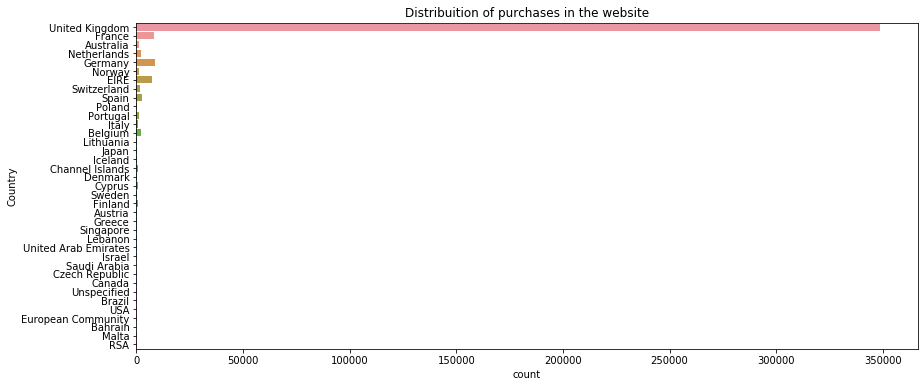

In [20]:
plt.figure(figsize=(14,6))
plt.title('Distribution of purchases in the website')
sns.countplot(y='Country', data=data)

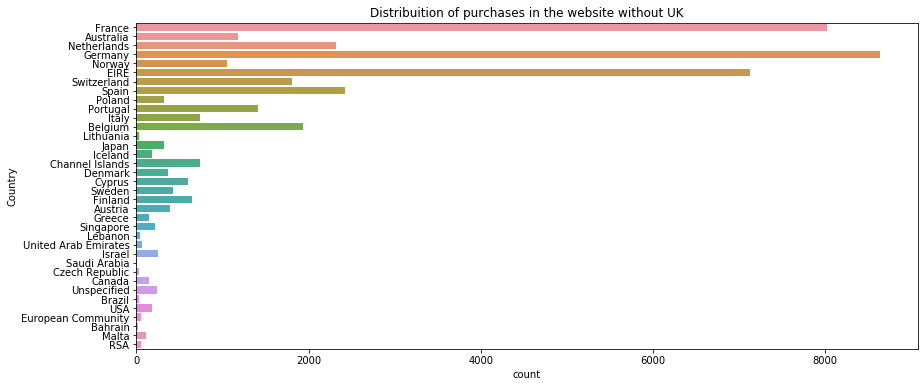

In [21]:
dis = data[data['Country']!= 'United Kingdom']
plt.figure(figsize=(14,6))
plt.title('Distribution of purchases in the website without UK')
sns.countplot(y='Country', data=dis)

I decided to make market basket analysis based on the top three purchases countries (UK, Germany, and France)

# 3. Market Basket Analysis

## United Kingdom

In [22]:
dfUK = data[data.Country=='United Kingdom'].reset_index(drop=True)
dfUK

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
348867,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
348868,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
348869,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
348870,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [23]:
# Dummy conding and creation of the baskets_sets, indexed by InvoiceNo with 1 corresponding to every item presented on the basket
# Note that the quantity bought is not considered, only if the item was present or not in the basket
dataUK = dfUK[['InvoiceNo','Description']]
catsub_UK = dfUK['Description']
catsub_UK = pd.get_dummies(catsub_UK)
basket_UK = pd.concat([dataUK, catsub_UK], axis = 1)
basket_UK.drop(labels=['Description'], axis=1, inplace=True)
basket_sets_UK = pd.pivot_table(basket_UK, index='InvoiceNo', aggfunc='max')
basket_sets_UK

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Apriori aplication: frequent_itemsets
# Note that min_support parameter was set to a very low value, this is the Spurious limitation, more on conclusion section
frequent_itemsets_UK = apriori(basket_sets_UK, min_support=0.02, use_colnames=True)
frequent_itemsets_UK['length'] = frequent_itemsets_UK['itemsets'].apply(lambda x: len(x))

# Advanced data frequent set selection
freq_UK = frequent_itemsets_UK[(frequent_itemsets_UK['length'] > 1) & (frequent_itemsets_UK['support'] >= 0.02)]
freq_UK

,support,itemsets,length
202,0.027384,"(ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELIKE GREEN)",2
203,0.027625,"(GARDENERS KNEELING PAD CUP OF TEA , GARDENERS KNEELING PAD KEEP CALM )",2
204,0.024368,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER)",2
205,0.028711,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGENCY TEACUP AND SAUCER)",2
206,0.024006,"(HEART OF WICKER SMALL, HEART OF WICKER LARGE)",2
207,0.020930,"(JUMBO BAG RED RETROSPOT, JUMBO BAG BAROQUE BLACK WHITE)",2
208,0.030521,"(JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKADOT)",2
209,0.023825,"(JUMBO BAG RED RETROSPOT, JUMBO BAG STRAWBERRY)",2
210,0.022498,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG RED RETROSPOT)",2
211,0.024609,"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)",2


In [28]:
# Generating the association_rules
rules_UK = association_rules(frequent_itemsets_UK, metric="lift", min_threshold=1)
rules_UK[['antecedents','consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
70,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )",(GREEN REGENCY TEACUP AND SAUCER),0.020568,0.890339,24.119179
71,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER ),0.020568,0.844059,20.639618
4,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.024368,0.819473,22.199406
7,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.028711,0.777778,19.018846
62,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.023102,0.776876,18.996802
2,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.027625,0.730463,16.321210
72,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGENCY TEACUP AND SAUCER)",(PINK REGENCY TEACUP AND SAUCER),0.020568,0.716387,24.091222
6,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.028711,0.702065,19.018846
73,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGENCY TEACUP AND SAUCER)",0.020568,0.691684,24.091222
64,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.025816,0.666667,5.866596


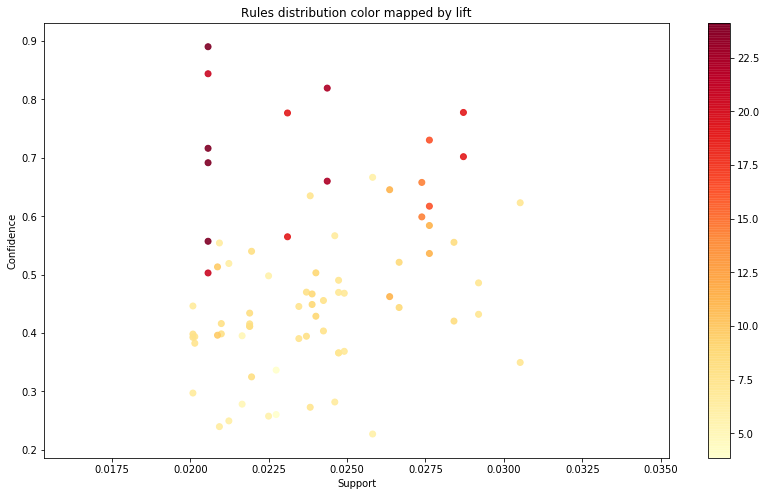

In [29]:
# Visualizing the rules distribution
plt.figure(figsize=(14,8))
plt.scatter(rules_UK['support'], rules_UK['confidence'], c=rules_UK['lift'], alpha=0.9, cmap='YlOrRd')
plt.title('Rules distribution color mapped by lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar()

## Germany

In [30]:
dfGerman = data[data.Country=='Germany'].reset_index(drop=True)
dfGerman

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536527,22809,SET OF 6 T-LIGHTS SANTA,6,2010-12-01 13:04:00,2.95,12662.0,Germany
1,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,2010-12-01 13:04:00,2.55,12662.0,Germany
2,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,2010-12-01 13:04:00,0.85,12662.0,Germany
3,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,2010-12-01 13:04:00,1.65,12662.0,Germany
4,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-01 13:04:00,1.95,12662.0,Germany
...,...,...,...,...,...,...,...,...
8638,581578,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09 12:16:00,1.25,12713.0,Germany
8639,581578,22907,PACK OF 20 NAPKINS PANTRY DESIGN,12,2011-12-09 12:16:00,0.85,12713.0,Germany
8640,581578,22908,PACK OF 20 NAPKINS RED APPLES,12,2011-12-09 12:16:00,0.85,12713.0,Germany
8641,581578,23215,JINGLE BELL HEART ANTIQUE SILVER,12,2011-12-09 12:16:00,2.08,12713.0,Germany


In [31]:
# Dummy conding and creation of the baskets_sets, indexed by InvoiceNo with 1 corresponding to every item presented on the basket
# Note that the quantity bought is not considered, only if the item was present or not in the basket
dataGerman = dfGerman[['InvoiceNo','Description']]
catsub_German = dfGerman['Description']
catsub_German = pd.get_dummies(catsub_German)
basket_German = pd.concat([dataGerman, catsub_German], axis = 1)
basket_German.drop(labels=['Description'], axis=1, inplace=True)
basket_sets_German = pd.pivot_table(basket_German, index='InvoiceNo', aggfunc='max')
basket_sets_German

,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Apriori aplication: frequent_itemsets
# Note that min_support parameter was set to a very low value, this is the Spurious limitation, more on conclusion section
frequent_itemsets_German = apriori(basket_sets_German, min_support=0.03, use_colnames=True)
frequent_itemsets_German['length'] = frequent_itemsets_German['itemsets'].apply(lambda x: len(x))

# Advanced data frequent set selection
freq_German = frequent_itemsets_German[(frequent_itemsets_German['length'] > 1) & (frequent_itemsets_German['support'] >= 0.03)]
freq_German

,support,itemsets,length
142,0.042889,"(REGENCY CAKESTAND 3 TIER, 6 RIBBONS RUSTIC CHARM)",2
143,0.036117,"(ROUND SNACK BOXES SET OF4 WOODLAND , 6 RIBBONS RUSTIC CHARM)",2
144,0.033860,"(BLUE HARMONICA IN BOX , ROUND SNACK BOXES SET OF4 WOODLAND )",2
145,0.036117,"(RED RETROSPOT CUP, BLUE POLKADOT CUP)",2
146,0.031603,"(CHARLOTTE BAG APPLES DESIGN, JUMBO BAG APPLES)",2
...,...,...,...
217,0.036117,"(PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN WOODLAND ANIMALS, ROUND SNACK BOXES SET OF4 WOODLAND )",3
218,0.042889,"(ROUND SNACK BOXES SET OF 4 FRUITS , PLASTERS IN TIN WOODLAND ANIMALS, ROUND SNACK BOXES SET OF4 WOODLAND )",3
219,0.031603,"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOTTE BAG, ROUND SNACK BOXES SET OF4 WOODLAND )",3
220,0.038375,"(ROUND SNACK BOXES SET OF 4 FRUITS , SPACEBOY LUNCH BOX , ROUND SNACK BOXES SET OF4 WOODLAND )",3


In [35]:
# Generating the association_rules
rules_German = association_rules(frequent_itemsets_German, metric="lift", min_threshold=1)
rules_German[['antecedents','consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
179,"(RED RETROSPOT CHARLOTTE BAG, ROUND SNACK BOXES SET OF4 WOODLAND )",(WOODLAND CHARLOTTE BAG),0.031603,1.000000,7.637931
184,"(ROUND SNACK BOXES SET OF 4 FRUITS , SPACEBOY LUNCH BOX )",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.038375,0.944444,3.735615
33,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.033860,0.937500,11.536458
26,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.033860,0.937500,14.321121
142,"(ROUND SNACK BOXES SET OF 4 FRUITS , CHARLOTTE BAG APPLES DESIGN)",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.031603,0.933333,3.691667
138,(SPACEBOY CHILDRENS BOWL),(SPACEBOY CHILDRENS CUP),0.038375,0.894737,19.818421
20,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.036117,0.888889,14.063492
135,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.047404,0.875000,14.908654
172,"(ROUND SNACK BOXES SET OF 4 FRUITS , PLASTERS IN TIN WOODLAND ANIMALS)",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.042889,0.863636,3.415990
190,"(ROUND SNACK BOXES SET OF 4 FRUITS , WOODLAND CHARLOTTE BAG)",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.040632,0.857143,3.390306


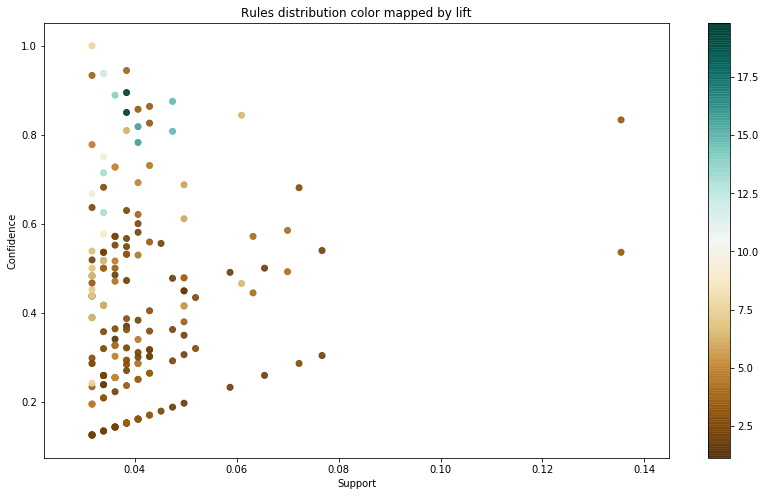

In [39]:
# Visualizing the rules distribution
plt.figure(figsize=(14,8))
plt.scatter(rules_German['support'], rules_German['confidence'], c=rules_German['lift'], alpha=0.9, cmap='BrBG')
plt.title('Rules distribution color mapped by lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar()

## France

In [40]:
dfFrance = data[data.Country=='France'].reset_index(drop=True)
dfFrance

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France
...,...,...,...,...,...,...,...,...
8014,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
8015,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
8016,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
8017,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [41]:
# Dummy conding and creation of the baskets_sets, indexed by InvoiceNo with 1 corresponding to every item presented on the basket
# Note that the quantity bought is not considered, only if the item was present or not in the basket
dataFrance = dfFrance[['InvoiceNo','Description']]
catsub_France = dfFrance['Description']
catsub_France = pd.get_dummies(catsub_France)
basket_France = pd.concat([dataFrance, catsub_France], axis = 1)
basket_France.drop(labels=['Description'], axis=1, inplace=True)
basket_sets_France = pd.pivot_table(basket_France, index='InvoiceNo', aggfunc='max')
basket_sets_France

,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,...,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Apriori aplication: frequent_itemsets
# Note that min_support parameter was set to a very low value, this is the Spurious limitation, more on conclusion section
frequent_itemsets_France = apriori(basket_sets_France, min_support=0.06, use_colnames=True)
frequent_itemsets_France['length'] = frequent_itemsets_France['itemsets'].apply(lambda x: len(x))

# Advanced data frequent set selection
freq_France = frequent_itemsets_France[(frequent_itemsets_France['length'] > 1) & (frequent_itemsets_France['support'] >= 0.06)]
freq_France

,support,itemsets,length
61,0.076517,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELIKE GREEN)",2
62,0.081794,"(ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELIKE GREEN)",2
63,0.076517,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELIKE RED )",2
64,0.065963,"(CHILDRENS CUTLERY SPACEBOY , CHILDRENS CUTLERY DOLLY GIRL )",2
65,0.073879,"(SPACEBOY LUNCH BOX , DOLLY GIRL LUNCH BOX)",2
66,0.068602,"(LUNCH BAG APPLE DESIGN, LUNCH BAG RED RETROSPOT)",2
67,0.065963,"(LUNCH BAG APPLE DESIGN, LUNCH BAG SPACEBOY DESIGN )",2
68,0.068602,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG RED RETROSPOT)",2
69,0.065963,"(LUNCH BAG WOODLAND, LUNCH BAG SPACEBOY DESIGN )",2
70,0.065963,"(LUNCH BOX WITH CUTLERY RETROSPOT , STRAWBERRY LUNCH BOX WITH CUTLERY)",2


In [45]:
# Generating the association_rules
rules_France = association_rules(frequent_itemsets_France, metric="lift", min_threshold=1)
rules_France[['antecedents','consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).head(10)

,antecedents,consequents,support,confidence,lift
48,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RETROSPOT PAPER NAPKINS )",(SET/6 RED SPOTTY PAPER CUPS),0.102902,0.975000,6.843056
50,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RED SPOTTY PAPER CUPS)",(SET/6 RED SPOTTY PAPER PLATES),0.102902,0.975000,7.390500
34,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.126649,0.960000,6.737778
6,(CHILDRENS CUTLERY SPACEBOY ),(CHILDRENS CUTLERY DOLLY GIRL ),0.065963,0.925926,12.533069
7,(CHILDRENS CUTLERY DOLLY GIRL ),(CHILDRENS CUTLERY SPACEBOY ),0.065963,0.892857,12.533069
35,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.126649,0.888889,6.737778
37,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELIKE GREEN)",(ALARM CLOCK BAKELIKE RED ),0.065963,0.862069,8.830382
36,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELIKE RED )",(ALARM CLOCK BAKELIKE GREEN),0.065963,0.862069,8.598004
2,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.081794,0.837838,8.356330
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.081794,0.815789,8.356330


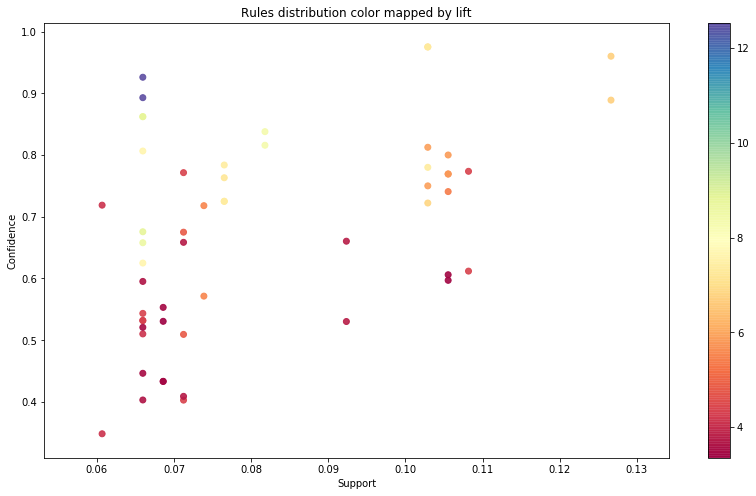

In [46]:
# Visualizing the rules distribution
plt.figure(figsize=(14,8))
plt.scatter(rules_France['support'], rules_France['confidence'], c=rules_France['lift'], alpha=0.9, cmap='Spectral')
plt.title('Rules distribution color mapped by lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar()

# Final Summary

### From above data analysis we can conclude that:

- We can know that the E-commerce has 3871 different products, 18402 total order transactions, serve 4334 customers and 37 countries worldwide.
- E-commerce has their biggest purchased in UK with 16579 invoice transactions in UK, followed by Germany and France with 1694 and 1541 respectively.
- E-commerce has almost sold all of its total products in UK with 3838 items (99%), while Germany and France with 443 items (11,45%) and 379 items (9,8%).
- Each Country has a different value support threshold with France with the highest score (0.06) than UK and Germany.
- Germany has confidence 100% in one of their products, it means the customers who buy RED RETROSPOT CHARLOTTE BAG and ROUND SNACK BOXES SET OF4 WOODLAND surely buy WOODLAND CHARLOTTE BAG product.
- In this case, each country has its customer tends to buy behavior products that we can see in each association rules completely.

### Statistical interpretation

[Click here](https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html) for explanations about the output attributes from this model and the statistical interpretation of how support, confidence and lift can correlate with marketing strategies and know the field where it's being applied.

### Apriori algorithm 
As seen on the article referenced above, we faced the Spurious Associations limitation. This happend due to the E-commerce business model, a large number of possibilities in a single basket among an even larger number of baskets. The consequence of it is having a "sparse matrix", full of 0s which causes the support of basket occurances to drop drastically.

### Insights gained from MBA in a number of ways, including:

- Grouping products that co-occur in the design of a store’s layout to increase the chance of cross-selling
- Driving online recommendation engines (customers who purchased this product also viewed this product)
- Targeting marketing campaigns by sending out promotional coupons to customers for products related to items they recently purchased.

I would like to close by mentioning that there is always scope for improvement, I also open to any other constructive comment that will be helped.

<img src="https://media1.tenor.com/images/251da9c5c43d4bf2e4ddb36ed6d4c2eb/tenor.gif?itemid=10603325" width="600px">